In [10]:
import numpy as np
import pandas as pd
import re, string

In [2]:
df = pd.read_csv("IMDB Dataset.csv")

In [29]:
sentiment_mapping = {
    'positive': 1,
    'negative': 0,
}
df['sentiment'] = df['sentiment'].map(sentiment_mapping)

In [30]:
print(df.shape)
df.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## Split Data

In [13]:
from sklearn.model_selection import train_test_split

In [32]:
X = df[['review']]
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(40000, 1) (10000, 1) (40000,) (10000,)


In [34]:
print(X_train)
y_train

                                                  review
39087  That's what I kept asking myself during the ma...
30893  I did not watch the entire movie. I could not ...
45278  A touching love story reminiscent of In the M...
16398  This latter-day Fulci schlocker is a totally a...
13653  First of all, I firmly believe that Norwegian ...
...                                                  ...
11284  `Shadow Magic' recaptures the joy and amazemen...
44732  I found this movie to be quite enjoyable and f...
38158  Avoid this one! It is a terrible movie. So wha...
860    This production was quite a surprise for me. I...
15795  This is a decent movie. Although little bit sh...

[40000 rows x 1 columns]


39087    0
30893    0
45278    1
16398    0
13653    0
        ..
11284    1
44732    1
38158    0
860      1
15795    1
Name: sentiment, Length: 40000, dtype: int64

## Bag of Words

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [97]:
# purpose of this function (1 point for each):
#  1. remove tags (things like <...>)
#  2. remove punctuation and make all letters lowercase
#  3. remove duplicate spaces, e.g. '     ' -> ' '
def process_string(text):
  text = re.sub(r'[^\w\s]', '', text)
  pattern = re.compile(r'<[^>]+>')
  # Replace HTML tags with an empty string
  text = pattern.sub('', text)
  text = re.sub(' +', ' ', text)
  text = re.sub(r'\bbr\b', '', text)
  # remove pronouns, determiners, coordinating conjunctions
  personal_pronouns = ["he", "she", "i", "we", "they", "him", "her", "us", "them", "me", "you"]
  determiners = ["the", "a", "an", "another", "this", "that", "these", "those", "my", "your", "his", "her", "its", "our", "their"]
  coordinating_conjunctions = ["for", "and", "nor", "but", "or", "yet", "so"]
  prepositions = ["in", "under", "towards", "before", "on", "at", "from", "with", "about", "into", "over", "after", "between", "against", "during", "without", "within", "through", "including", "until", "against"]

  words_to_remove = set(personal_pronouns + determiners + coordinating_conjunctions + prepositions)

  # Remove words
  words = text.lower().split()
  cleaned_words = [word for word in words if word not in words_to_remove]
  return cleaned_words

In [24]:
X_train_processed = X_train['review'].apply(process_string)
X_test_processed = X_test['review'].apply(process_string)

In [26]:
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train_processed)
X_test_counts = count_vect.transform(X_test_processed)

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter = 1000)
model.fit(X_train_counts, y_train)
y_pred = model.predict(X_test_counts)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8923


## Stemming/Lemmatization

In [60]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alyssaliu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [51]:
lemmatizer = WordNetLemmatizer()

In [57]:
process_string(example_text)

['am', 'happily', 'reading', 'book', 'tree']

In [98]:
def get_wordnet_pos(treebank_tag):
    """Convert the part-of-speech naming scheme from the Penn Treebank to that which is recognized by WordNet."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun
        
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = process_string(text)
    lemmatized_sentence = []

    for word, tag in pos_tag(tokens):
        wordnet_pos = get_wordnet_pos(tag)
        lemmatized_sentence.append(lemmatizer.lemmatize(word, wordnet_pos))
    return ' '.join(lemmatized_sentence)

In [71]:
lemmatize_text(example_text)

'be happily read book tree'

In [75]:
positive_reviews = df[df['sentiment'] == 1]['review']
negative_reviews = df[df['sentiment'] == 0]['review']

In [93]:
positive_reviews

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
4        Petter Mattei's "Love in the Time of Money" is...
5        Probably my all-time favorite movie, a story o...
                               ...                        
49983    I loved it, having been a fan of the original ...
49985    Imaginary Heroes is clearly the best film of t...
49989    I got this one a few weeks ago and love it! It...
49992    John Garfield plays a Marine who is blinded by...
49995    I thought this movie did a down right good job...
Name: review, Length: 25000, dtype: object

In [99]:
positive_reviews[1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [100]:
lemmatize_text(positive_reviews[1])

'wonderful little production filming technique be very unassuming very oldtimebbc fashion give comfort sometimes discomforting sense of realism to entire piece actor be extremely well choose michael sheen not only have get all polari have all voice down pat too can truly see seamless edit guide by reference to williams diary entry not only be it well worth watch it be terrificly write perform piece masterful production one of great master of comedy life realism really come home little thing fantasy of guard which rather than use traditional dream technique remain solid then disappear it play knowledge sens particularly scene concern orton halliwell set particularly of flat halliwells mural decorate every surface be terribly well do'

In [101]:
positive_reviews_processed = positive_reviews.apply(lemmatize_text)
negative_reviews_processed = negative_reviews.apply(lemmatize_text)

In [102]:
positive_reviews_processed

0        one of other reviewer have mention watch just ...
1        wonderful little production filming technique ...
2        thought be wonderful way to spend time too hot...
4        petter matteis love time of money be visually ...
5        probably alltime favorite movie story of selfl...
                               ...                        
49983    love it have be fan of original series have al...
49985    imaginary hero be clearly best film of year it...
49989    get one few week ago love it modern light fill...
49992    john garfield play marine who be blind by gren...
49995    thought movie do down right good job it wasnt ...
Name: review, Length: 25000, dtype: object

In [82]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

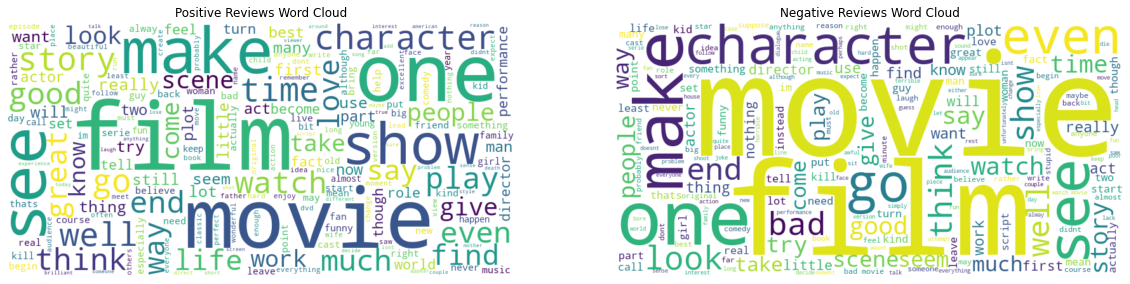

In [103]:
wordcloud_pos = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(positive_reviews_processed))
wordcloud_neg = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(negative_reviews_processed))

# Display word clouds
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()

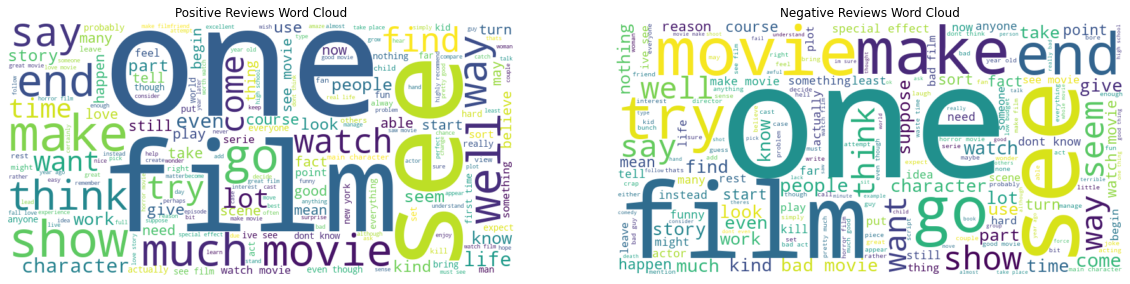

In [104]:
wordcloud_pos = WordCloud(width=800, height=400, background_color ='white', collocation_threshold = 3).generate(' '.join(positive_reviews_processed))
wordcloud_neg = WordCloud(width=800, height=400, background_color ='white', collocation_threshold = 3).generate(' '.join(negative_reviews_processed))

# Display word clouds
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()

In [114]:
positive_reviews_processed.to_pickle('pos_reviews.pkl')
negative_reviews_processed.to_pickle('neg_reviews.pkl')

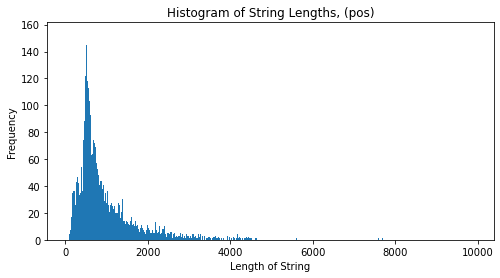

In [118]:
pos_lengths = positive_reviews_processed.str.len()

plt.figure(figsize=(8, 4))
plt.hist(pos_lengths, bins=len(pos_lengths.unique()))
plt.title('Histogram of String Lengths, (pos)')
plt.xlabel('Length of String')
plt.ylabel('Frequency')
# plt.xticks(range(min(pos_lengths), max(pos_lengths)+1))  # Set x-ticks to match string lengths
plt.show()

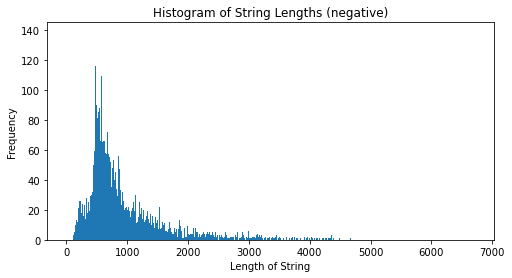

In [117]:
neg_lengths = negative_reviews_processed.str.len()

plt.figure(figsize=(8, 4))
plt.hist(neg_lengths, bins=len(neg_lengths.unique()))
plt.title('Histogram of String Lengths (negative)')
plt.xlabel('Length of String')
plt.ylabel('Frequency')
# plt.xticks(range(min(neg_lengths), max(neg_lengths)+1))  # Set x-ticks to match string lengths
plt.show()